In [1]:
# imports
from tqdm import tqdm # progressbar
import os
import numpy as np
from astropy.stats import mad_std
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from wpca import WPCA # JVDP's weighted PCA library

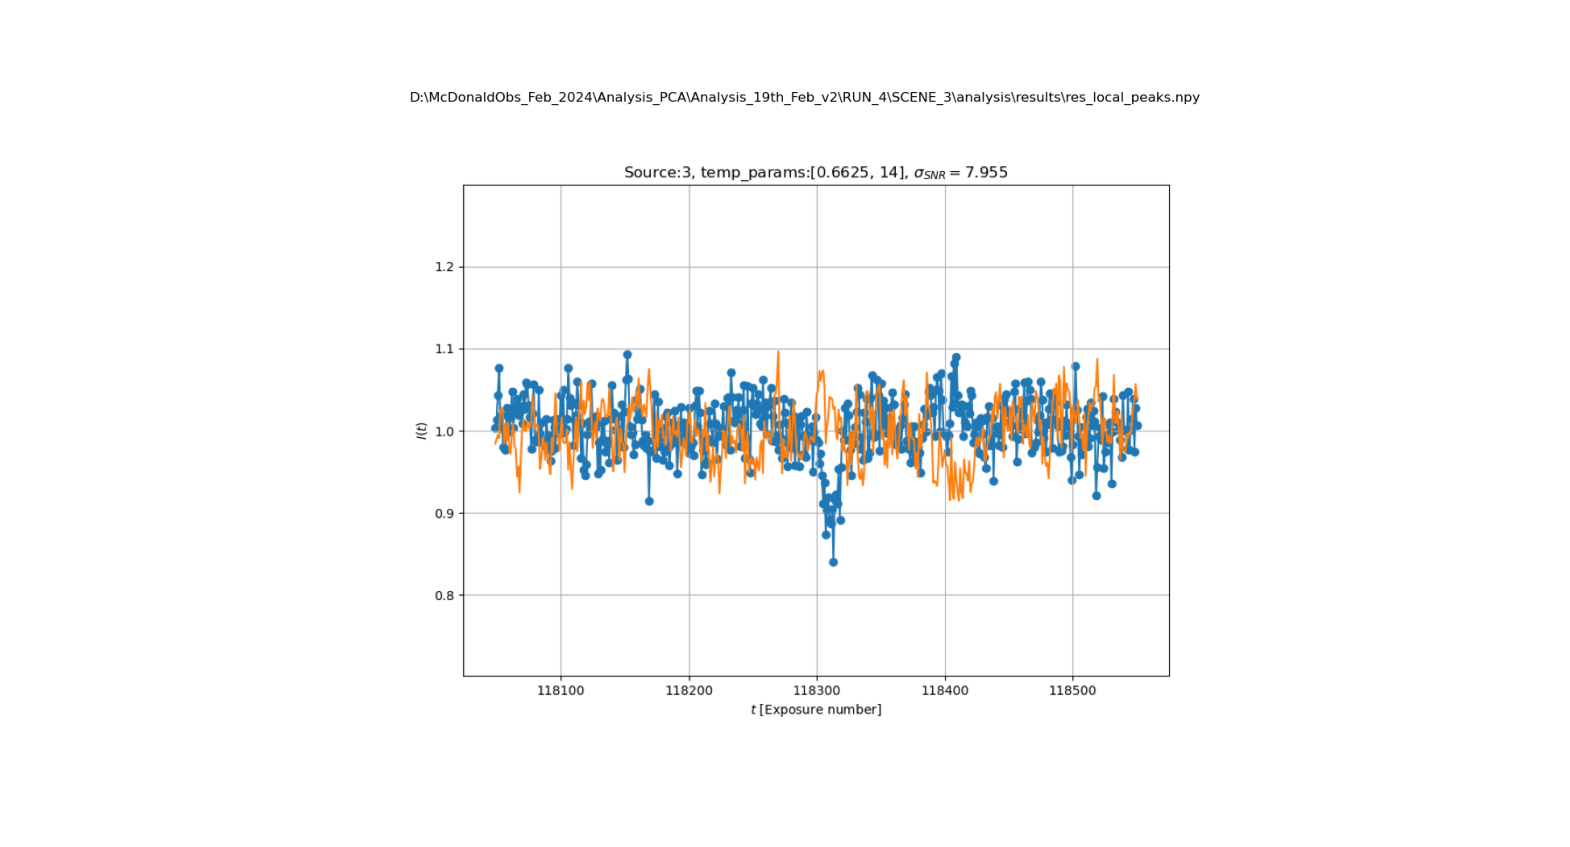

In [2]:
# load candidate event image
#img_path = 'D:/test_images/Analysis_18th_Feb_v2_RUN_2_SCENE_0_0_178569.png' # maybe
#img_path = 'D:/test_images/Analysis_16th_Feb_v2_RUN_14_SCENE_0_28_281816.png' # nada
#img_path = 'D:/test_images/Analysis_20th_Feb_v2_RUN_2_SCENE_0_0_142677.png' # probably not
#img_path = 'D:/test_images/Analysis_20th_Feb_v2_RUN_1_SCENE_1_0_353378.png'# nada
img_path = 'D:/test_images/Analysis_19th_Feb_v2_RUN_4_SCENE_3_3_117581.png'# probably not
#img_path = 'D:/test_images/Analysis_16th_Feb_v2_RUN_17_SCENE_0_0_41611.png'
#img_path = 'D:/test_images/Analysis_19th_Feb_v2_RUN_4_SCENE_2_0_78399.png'
img = mpimg.imread(img_path)
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.axis('off');

In [3]:
# dip time
#t_peak = int(img_path.split('.')[0].split('_')[-1])
t_peak = 118310 #180275 #143585 #78995 #42065

In [4]:
# load event data (sub dir path)
#s = 'D:/McDonaldObs_Feb_2024/Results_18th_Feb/RUN_2/SCENE_0/photometry/'
#s = 'D:/McDonaldObs_Feb_2024/Results_16th_Feb/RUN_14/SCENE_0/photometry/'
#s = 'D:/McDonaldObs_Feb_2024/Results_20th_Feb/RUN_2/SCENE_0/photometry/'
#s = 'D:/McDonaldObs_Feb_2024/Results_20th_Feb/RUN_1/SCENE_1/photometry/'
s = 'D:/McDonaldObs_Feb_2024/Results_19th_Feb/RUN_4/SCENE_3/photometry/'
#s = 'D:/McDonaldObs_Feb_2024/Results_16th_Feb/RUN_17/SCENE_0/photometry/'
#s = 'D:/McDonaldObs_Feb_2024/Results_19th_Feb/RUN_4/SCENE_2/photometry/'

def order_files(subdir):

    # grab all files in the subdir
    files = [f for d, s, f in os.walk(subdir)][0]

    # order the files
    phot_files = []
    seq_files = []
    sky_files = []
    batch_ids = np.arange(0, 1000).astype(str)
    for b in batch_ids:
        for f in files:
            if 'photometry' in f and 'batch' + b + '.npy' in f:
                phot_files.append(f)
            elif 'seq' in f and 'batch' + b + '.npy' in f:
                seq_files.append(f)
            elif 'sky' in f and 'batch' + b + '.npy' in f:
                sky_files.append(f)

    return phot_files, seq_files, sky_files

def batch_files(files, arr, path):
    for i,file in enumerate(files):
        arr[i] = np.load(os.path.join(path, file))
    return arr

# grab files
phot_files, seq_files, sky_files = order_files(s)

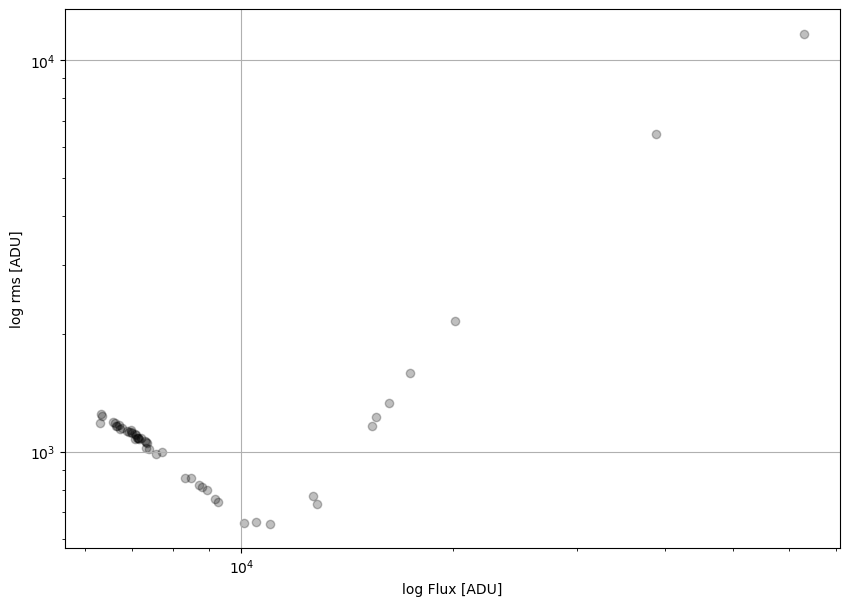

In [5]:
# setup dimensions for the data matrix
fs = np.load(os.path.join(s, phot_files[0])) # use for shape info
ss = np.load(os.path.join(s, sky_files[0]))
data = np.zeros((len(phot_files), fs.shape[0], fs.shape[1])) # data matrix
t = np.zeros((len(seq_files), fs.shape[0])) # observation sequence numbers (i.e. time)
bkgs = np.zeros((len(sky_files), ss.shape[0], ss.shape[1]))

# staple together the data in files
data = batch_files(phot_files, data, s)
t = batch_files(seq_files, t, s)
bkgs = batch_files(sky_files, bkgs, s)

# reshape and change dtype
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2]).astype(np.float32)
bkgs = bkgs.reshape(bkgs.shape[0] * bkgs.shape[1], bkgs.shape[2]).astype(np.float32)
t = t.flatten().astype(np.float32)

# generate data matrix
X = np.copy(data)

# plot of std vs median flux
plt.figure(figsize=(10,7))
plt.scatter(np.median(X, axis=0), np.std(X, axis=0)[:, None], alpha=0.25, c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log Flux [ADU]')
plt.ylabel('log rms [ADU]')
plt.grid()
plt.show();

In [6]:
# systematic variation is a funtion of flux, so normalise out
X_norm = X / np.median(X, axis=0)

###################### fit WPCA model #########################
X_norm = X_norm.T  # reshape to data matrix is n_samples x n_features
print('Data matrix shape:', X_norm.shape)
X_norm -= np.median(X_norm, axis=1)[:, None] # centre rows

Data matrix shape: (49, 354500)


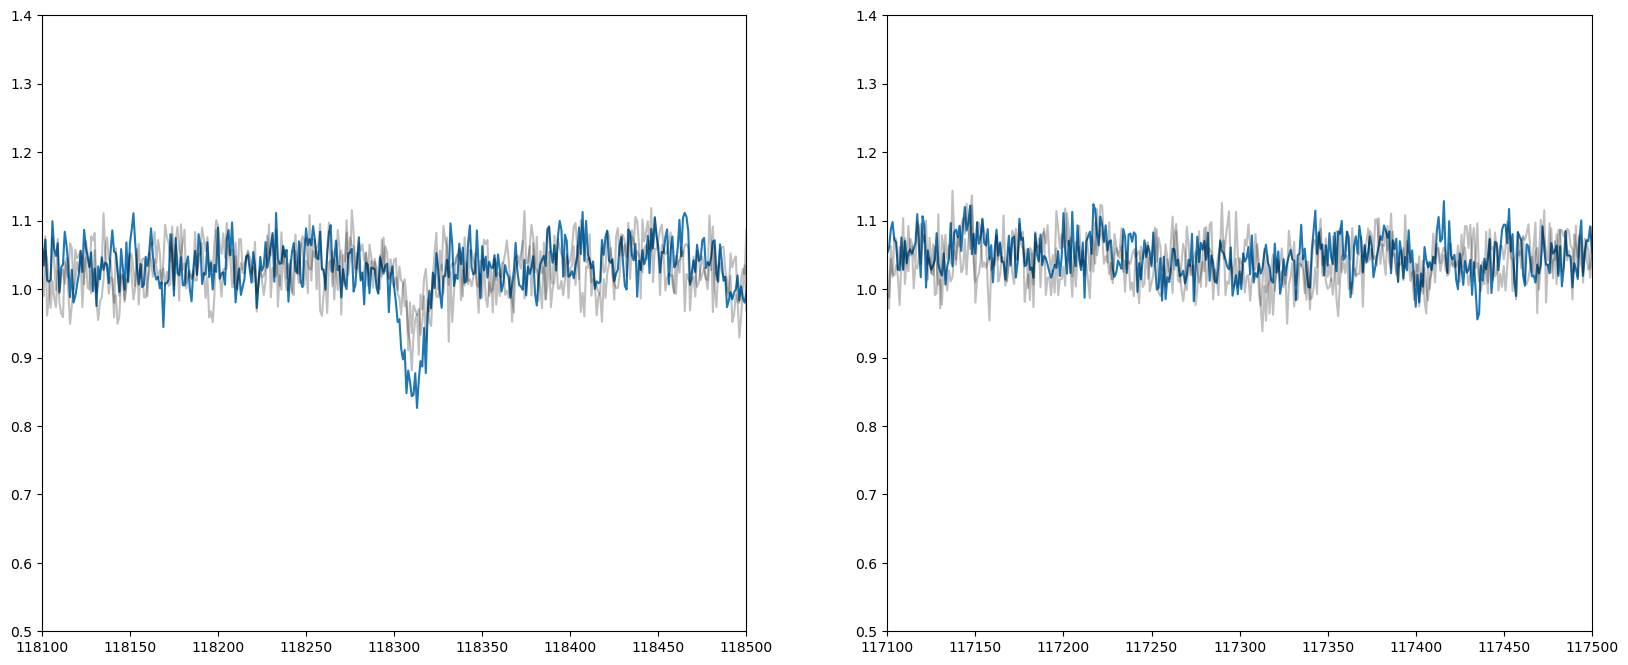

In [9]:
# plot raw data around event location
#candidate = 0
#sources = [candidate, 1, 2] #  [candidate, 8, 13] 
#candidate = 28
#sources = [candidate, 6, 44]
#candidate = 0
#sources = [candidate, 2, 11]
#candidate = 0
#sources = [candidate, 2, 2]
candidate = 3
sources = [candidate, 4, 6]
#candidate = 0
#sources = [candidate, 1, 4]
#candidate = 0
#sources = [candidate, 2, 11]

#xmin, xmax = 180000, 180550
#ymin, ymax = 0.8, 1.2
#xmin, xmax = 283100, 283500
#ymin, ymax = 0.5, 1.2
#xmin, xmax = 143300, 143900 #143300, 143800
#ymin, ymax = 0.5, 1.4
#xmin, xmax = 354900, 355400
#ymin, ymax = 0.5, 1.4
xmin, xmax = 118100, 118500
ymin, ymax = 0.5, 1.4
#xmin, xmax = 41800, 42300
#ymin, ymax = 0.5, 1.4
#xmin, xmax = 78800, 79200
#ymin, ymax = 0.5, 1.4

shift = -1000
alpha = 0.25
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax[0].plot(t, X_norm[candidate] + 1)
ax[0].plot(t, X_norm[sources[1]] + 1, c='k', alpha=alpha)
ax[0].plot(t, X_norm[sources[2]] + 1, c='k', alpha=alpha)
#ax[0].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax);
ax[1].plot(t, X_norm[candidate] + 1)
ax[1].plot(t, X_norm[sources[1]] + 1, c='k', alpha=alpha)
ax[1].plot(t, X_norm[sources[2]] + 1, c='k', alpha=alpha)
#ax[1].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[1].set_xlim(xmin + shift, xmax + shift)
ax[1].set_ylim(ymin, ymax);

In [10]:
# compute time relative to dip
t_rel = t - t_peak
t_rel_s = (12e-3) * t_rel # time in seconds

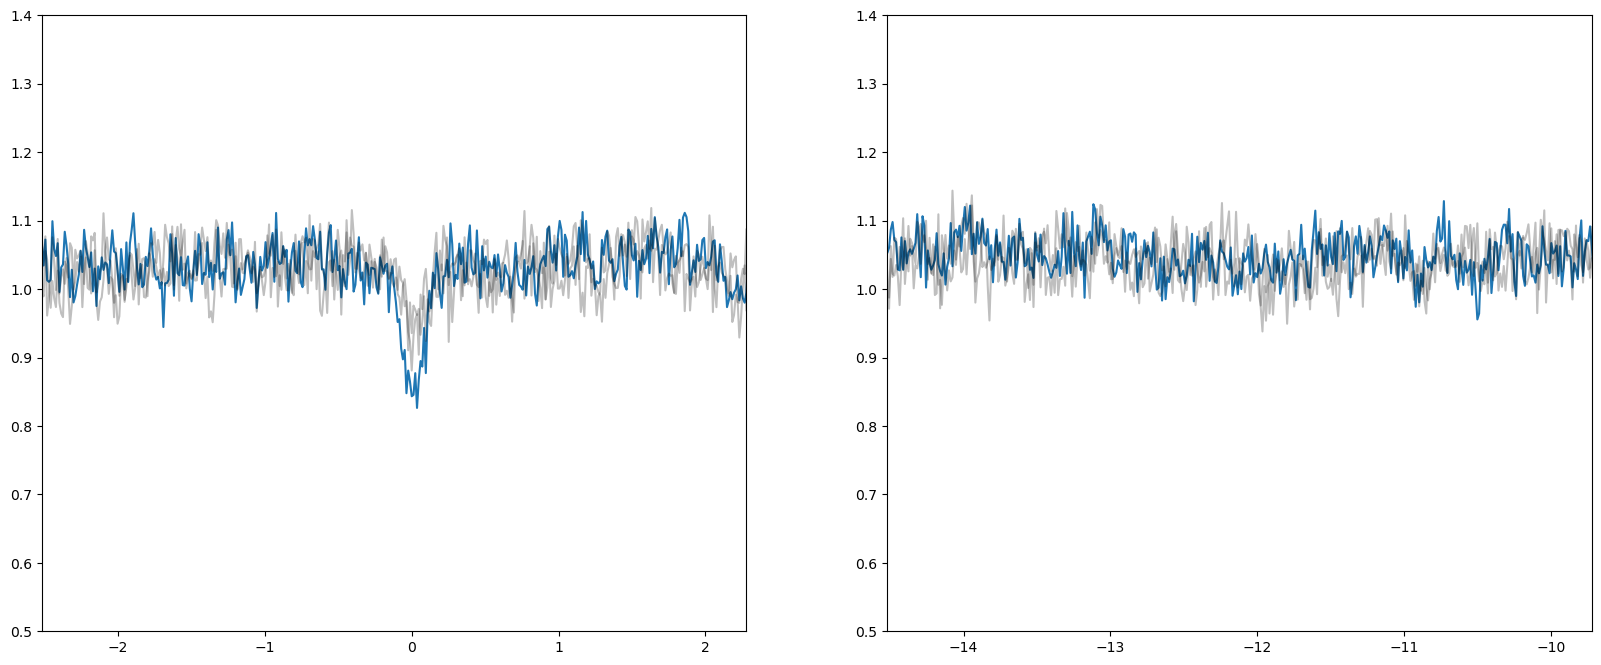

In [11]:
# plot raw data around event location
xmin_, xmax_ = 12e-3 * (xmin - t_peak), 12e-3 * (xmax - t_peak)
shift = -1000 * 12e-3
alpha = 0.25
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax[0].plot(t_rel_s, X_norm[candidate] + 1)
ax[0].plot(t_rel_s, X_norm[sources[1]] + 1, c='k', alpha=alpha)
ax[0].plot(t_rel_s, X_norm[sources[2]] + 1, c='k', alpha=alpha)
#ax[0].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[0].set_xlim(xmin_, xmax_)
ax[0].set_ylim(ymin, ymax);
ax[1].plot(t_rel_s, X_norm[candidate] + 1)
ax[1].plot(t_rel_s, X_norm[sources[1]] + 1, c='k', alpha=alpha)
ax[1].plot(t_rel_s, X_norm[sources[2]] + 1, c='k', alpha=alpha)
#ax[1].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[1].set_xlim(xmin_ + shift, xmax_ + shift)
ax[1].set_ylim(ymin, ymax);

In [12]:
# number of PCA components
N_COMPONENTS = 8
lcs = []
window = 1000 # window to assess correlation outside dip
indices = np.where((t >= xmin) & (t <= xmax))[0] # lc slice
t_ = t[indices[0] - window : indices[-1] + window]
for source in tqdm(sources):

    # split time series into manageable chunks
    T = X_norm.shape[1]

    # slice out data chunk
    X_norm_ = X_norm[:,indices[0] - window : indices[-1] + window]

    # define weights as the inverse of the (normalised) time series variance
    weights = 1/np.var(X_norm_, axis=1)
    weights = weights[:,None] * np.ones(X_norm_.shape)
    weights[source] = 1e-6 * np.ones(weights[source].shape) # weight out the target star (using 0s result in Singular matrix error)
    weights[candidate] = 1e-6 * np.ones(weights[candidate].shape) # weight out candidate event
    
    pca = WPCA(n_components=N_COMPONENTS).fit(X_norm_, weights=weights) # fit pca model
    Y = pca.fit_reconstruct(X_norm_, weights=weights) # make predictions

    # compute residuals (i.e. "detrended" time series)
    residuals_ = X_norm_[source] - Y[source]
    residuals_ += 1 # shift time series such that median I(t) is 1
    
    # store detrended time series
    lcs.append(residuals_)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:38<00:00, 12.94s/it]


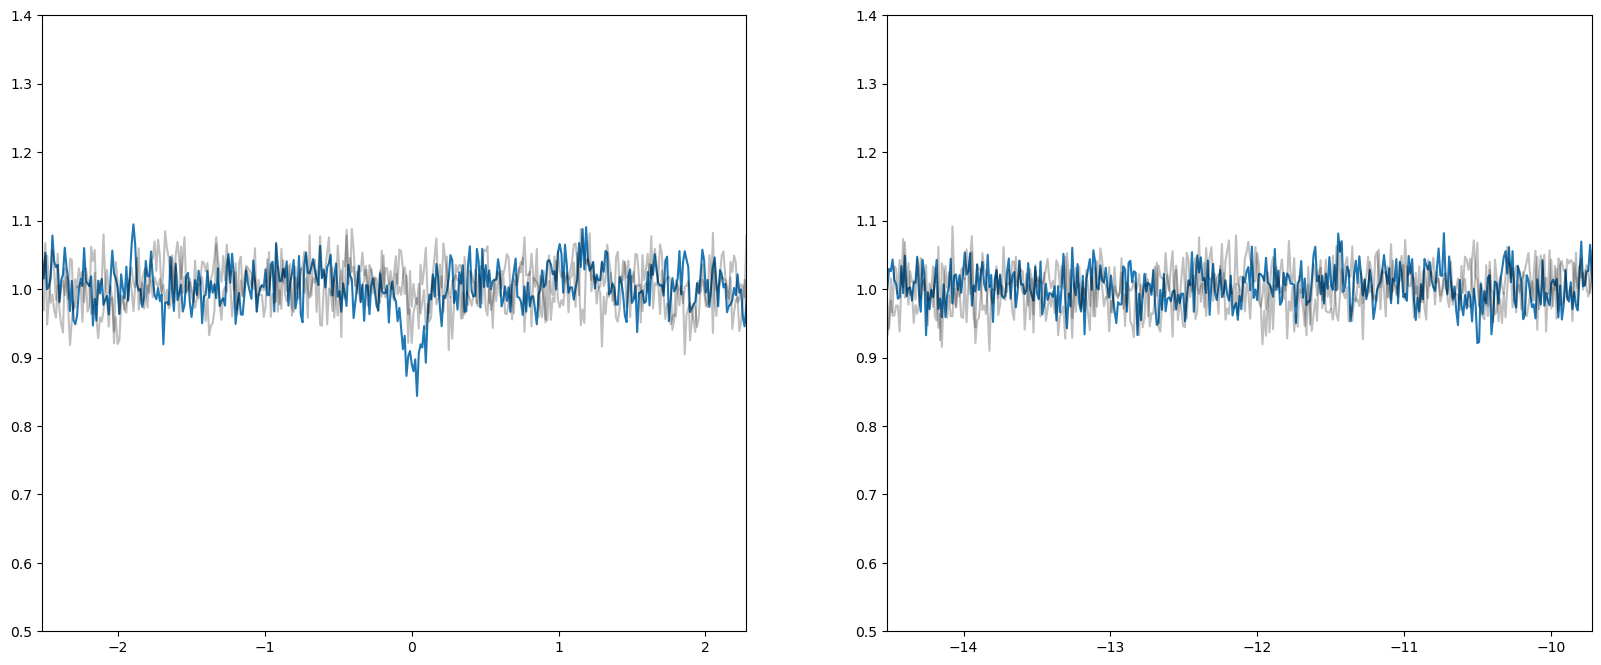

In [13]:
# plot deterended data around event location
alpha = 0.25
#xmin, xmax = 180000, 180500
#ymin, ymax = 0.8, 1.2
shift = -1000 * 12e-3
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[0])
ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[1], c='k', alpha=alpha)
ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[2], c='k', alpha=alpha)
#ax[0].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[0].set_xlim(xmin_, xmax_)
ax[0].set_ylim(ymin, ymax);
ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[0])
ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[1], c='k', alpha=alpha)
ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[2], c='k', alpha=alpha)
#ax[1].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[1].set_xlim(xmin_ + shift, xmax_ + shift)
ax[1].set_ylim(ymin, ymax);

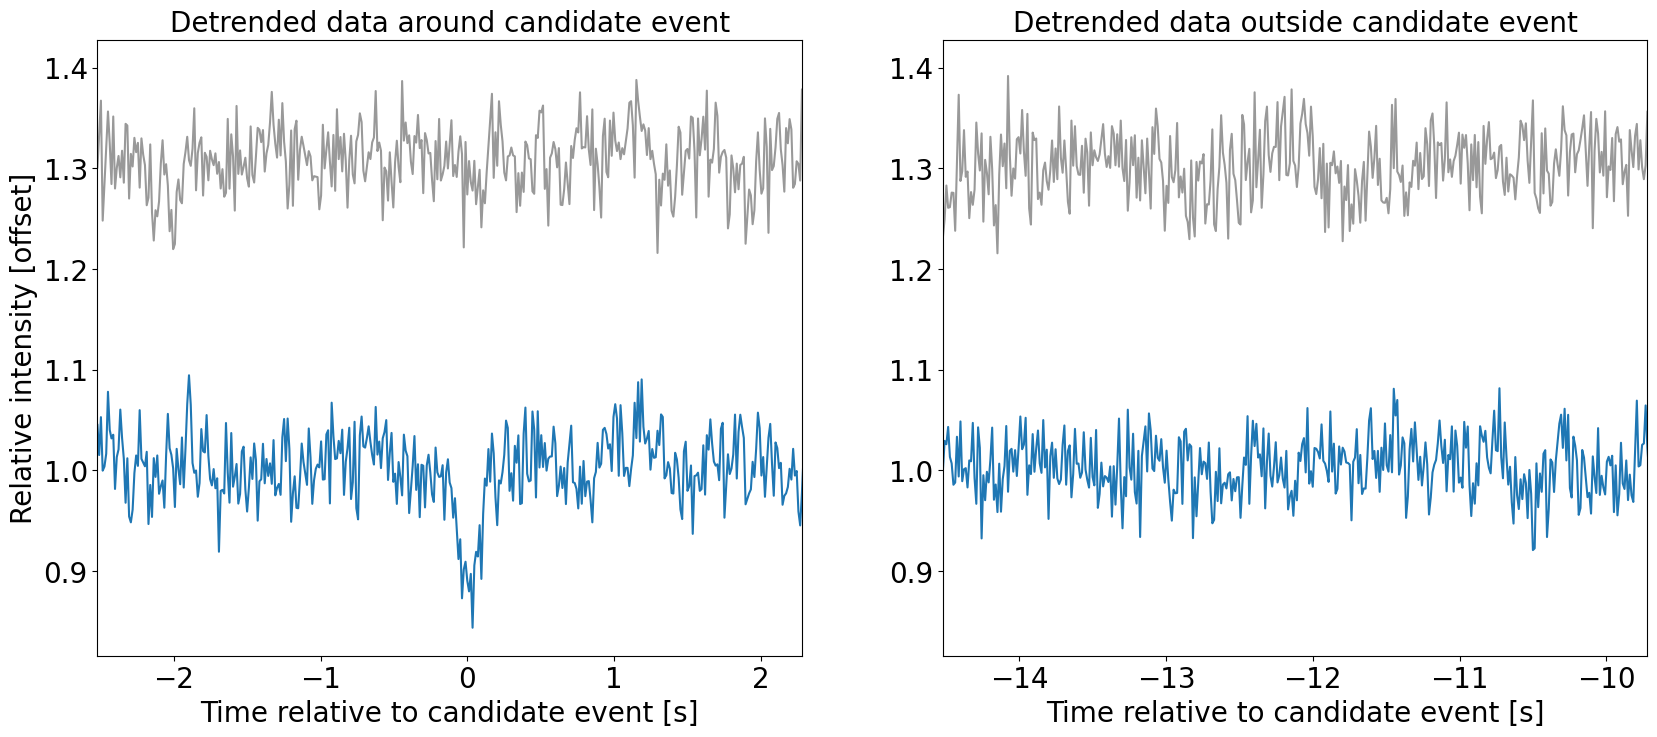

In [14]:
# plot deterended data around event location
fs = 20
alpha = 0.4
shift = - 1000 * 12e-3
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[0])
ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[1] + 0.3, c='k', alpha=alpha)
#ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[2] + 0.6, c='k', alpha=alpha)
#ax[0].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[0].set_xlim(xmin_, xmax_)
ax[0].set_xlabel('Time relative to candidate event [s]', fontsize=fs)
ax[0].set_ylabel('Relative intensity [offset]', fontsize=fs)
ax[0].set_title('Detrended data around candidate event', fontsize=fs)
#ax[0].set_ylim(ymin, ymax);
ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[0])
ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[1] + 0.3, c='k', alpha=alpha)
#ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], lcs[2] + 0.6, c='k', alpha=alpha)
#ax[1].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[1].set_xlim(xmin_ + shift, xmax_ + shift)
#ax[1].set_ylim(ymin, ymax);
ax[1].set_xlabel('Time relative to candidate event [s]', fontsize=fs)
ax[1].set_title('Detrended data outside candidate event',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs);

Text(0.5, 1.0, 'Raw data outside dip event')

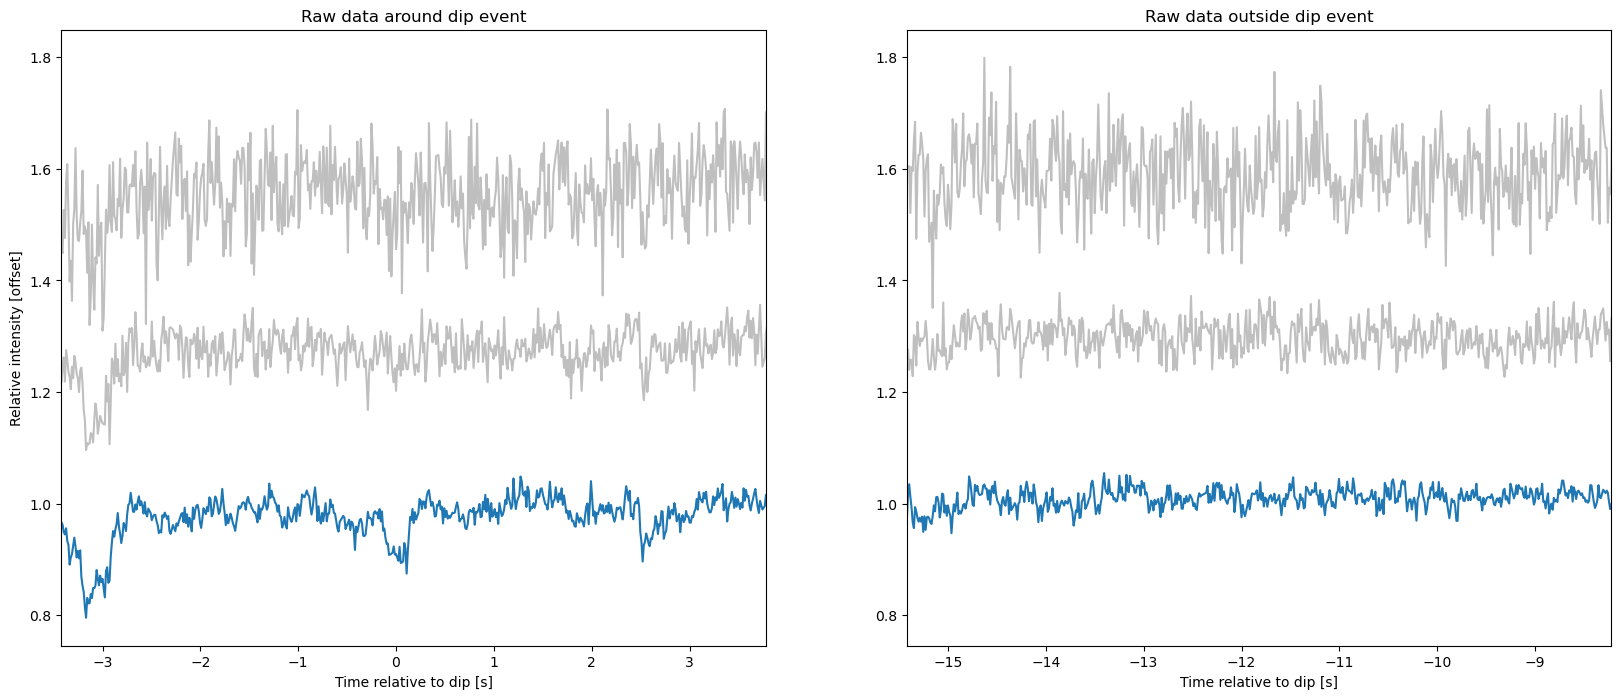

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], X_norm[candidate][indices[0] - window : indices[-1] + window] + 1)
ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], X_norm[sources[1]][indices[0] - window : indices[-1] + window] + 1.3, c='k', alpha=alpha)
ax[0].plot(t_rel_s[indices[0] - window : indices[-1] + window], X_norm[sources[2]][indices[0] - window : indices[-1] + window] + 1.6, c='k', alpha=alpha)
#ax[0].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[0].set_xlim(xmin_, xmax_)
ax[0].set_xlabel('Time relative to dip [s]')
ax[0].set_ylabel('Relative intensity [offset]')
ax[0].set_title('Raw data around dip event')
#ax[0].set_ylim(ymin, ymax);
ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], X_norm[candidate][indices[0] - window : indices[-1] + window] + 1)
ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], X_norm[sources[1]][indices[0] - window : indices[-1] + window] + 1.3, c='k', alpha=alpha)
ax[1].plot(t_rel_s[indices[0] - window : indices[-1] + window], X_norm[sources[2]][indices[0] - window : indices[-1] + window] + 1.6, c='k', alpha=alpha)
#ax[1].plot(t, X_norm[3] + 1, c='k', alpha=alpha)
ax[1].set_xlim(xmin_ + shift, xmax_ + shift)
#ax[1].set_ylim(ymin, ymax);
ax[1].set_xlabel('Time relative to dip [s]')
ax[1].set_title('Raw data outside dip event')

In [14]:
# imports
from math import hypot, ceil
import numpy as np
from math import pi, cos, tan
from scipy.special import jv  # Bessel function
from itertools import product
import matplotlib.pyplot as plt


class memoize:

    """ Memoization decorator to cache repeatedly-used function calls """

    # stock code from http://avinashv.net

    def __init__(self, function):
        self.function = function
        self.memoized = {}

    def __call__(self, *args):
        try:
            return self.memoized[args]
        except KeyError:
            self.memoized[args] = self.function(*args)
            return self.memoized[args]


@memoize
def lommel(n, a, b):

    """ Calculates the nth lommel function """

    U = 0
    for k in range(0, 100000):
        sum = ((-1)**k * (a/b)**(n+2*k) * jv(n+2*k, pi*a*b))
        U += sum
        if abs(sum) < 0.00001:
            return U
    raise ValueError("Failure to converge")


@memoize
def generatePoints(starR):

    """ Models star as an array of uniformly distributed point sources """

    if starR == 0:  # model as point source
        return np.array([(0,0)])
    n = 5  # number of points to model 1D radius of star
    pairs = np.array([item for item in product(np.linspace(-starR, starR, 2*n-1), repeat=2) if hypot(item[0], item[1]) <= starR])
    return pairs


def diffractionCalc(r, p, starR, lam, D, b):

    """ Analytically calculates intensity at a given distance from star centre """

    # r is distance between line of sight and centre of the disk, in fresnel scale units
    # p is radius of KBO, in fresnel scale units
    pts = generatePoints(starR)
    r = fresnel(r, lam, D)
    res = 0
    effR = np.round(np.hypot((r - pts[:, 0]), (pts[:, 1]-b)), 2)
    coslist = np.cos(0.5*pi*(effR**2 + p**2))
    sinlist = np.sin(0.5*pi*(effR**2 + p**2))
    l = len(pts)
    for n in range(0, l):
        if effR[n] > p:
            U1 = lommel(1, p, effR[n])
            U2 = lommel(2, p, effR[n])
            res += (1 + (U2 ** 2) + (U1 ** 2) + 2*(U2*coslist[n] - U1*sinlist[n]))
        elif effR[n] == p:
            res += (0.25 * ((jv(0, pi*p*p)**2) + 2*cos(pi*p*p)*jv(0, pi*p*p) + 1))
        else:
            res += ((lommel(0, effR[n], p)**2) + (lommel(1, effR[n], p) ** 2))
    return res / l


def fresnel(x, lam, D):

    """ Converts value to fresnel scale units """
    return x / (lam*D/2.)**(1/2.)


def generateKernel(lam, objectR, b, D, starR):

    """ Calculates the light curve at a given wavelength """

    p = fresnel(objectR, lam, D)  # converting KBO radius to Fresnel Scale
    s = fresnel(starR, lam, D)  # converting effective star radius to Fresnel Scale
    b = fresnel(b, lam, D)
    #r = 25000.  # distance between line of sight and centre of the disk in m
    r = 50000
    z = [diffractionCalc(j, p, s, lam, D, b) for j in np.arange(-r, r, 10)]
    return z


def defineParam(startLam, endLam, objectR, b, D, angDi):

    """ Simulates light curve for given parameters """

    # startLam: start of wavelength range, m
    # endLam: end of wavelength range, m
    # objectR: radius of KBO, m
    # b: impact parameter, m
    # D: distance from KBO to observer, in AU
    # angDi: angular diameter of star, mas
    # Y: light profile during diffraction event

    D *= 1.496e+11 # converting to metres
    starR = effStarRad(angDi, D)
    n = 18
    weights = np.array([0.19570672, 0.25023261, 0.2839096 , 0.21618307, 1.        ,
       0.99264115, 0.7642776 , 0.60915081, 0.47424386, 0.36451124,
       0.27732518, 0.20631212, 0.14537288, 0.09838498, 0.06365699,
       0.03863518, 0.02244682, 0.00967328])
    if endLam == startLam:
        Y = generateKernel(startLam, objectR, b, D, starR)
    else:
        step = (endLam-startLam) / n
        Y = np.array([generateKernel(lam, objectR, b, D, starR) for lam in np.arange(startLam, endLam, step)])
        #Y = np.sum(Y, axis=0)
        #Y /= n
        Y = np.average(Y, weights=weights, axis=0)
    return Y


def effStarRad(angDi, D):

    """ Determines projected star radius at KBO distance """

    angDi /= 206265000.  # convert to radians
    return D * tan(angDi / 2.)


def vT(a, phi, vE):

    """ Calculates transverse velocity of KBO """

    # a is distance to KBO, in AU
    # phi is opposition angle, degrees
    # vE is Earth's orbital speed, in m/s
    # returns vT, transverse KBO velocity, in m/s

    phi_ = phi * (np.pi / 180) # degrees -> radians
    #return vE * ( 1 - (1./a)**(1/2.))
    return vE * (np.cos(phi_) - ((1./a) * (1 - (np.sin(phi_) ** 2)))**(1/2))


def integrateCurve(exposure, curve, totTime, shiftAdj):

    """ Reduces resolution of simulated light curve to match what would be observed for a given exposure time """

    curve = np.array(curve)
    timePerFrame = totTime / len(curve)
    numFrames = roundOdd(exposure/timePerFrame)
    if shiftAdj < 0:
        shiftAdj += 1
    shift = ((len(curve) / 2)% numFrames) - (numFrames-1)/2
    while shift < 0:
        shift += numFrames
    shift += int(numFrames*shiftAdj)
    for index in np.arange((numFrames-1)/2 + shift, len(curve)-(numFrames-1)/2, numFrames):
        indices = range(int(index - (numFrames-1)/2), int(index+1+(numFrames-1)/2))
        av = np.average(curve[indices])
        curve[indices] = av
    last = indices[-1]+1  # bins leftover if light curve length isn't divisible by exposure time
    shift = int(shift)
    curve[last:] = np.average(curve[last:])
    curve[:shift] = np.average(curve[:shift])
    return curve, numFrames


def roundOdd(x):

    """ Rounds x to the nearest odd integer """

    x = ceil(x)
    if x % 2 == 0:
        return int(x-1)
    return int(x)


def genCurve(exposure, startLam, endLam, objectRad, impact, dist, angDi, shiftAdj, phi):

    """ Convert diffraction pattern to time series """

    velT = vT(dist, phi, 29800)
    curve = defineParam(startLam, endLam, objectRad, impact, dist, angDi)
    n = len(curve)*10./velT
    curve, num = integrateCurve(exposure, curve, n, shiftAdj)
    return curve[::num]

In [178]:
'''
# AOV star in M46 (Open cluster)
r_sol = 696340 # km
pc_km = 3.086e13 # km/pc
#d_star = 2 * (1.87 * r_sol) # aov diameter km
d_star = 2 * (5 * r_sol) # aov diameter km
#angular_size = 206265 * (d_star / (pc_km * 1510)) # arcsec -> rad (km / (km/pc * pc))
angular_size = 206265 * (d_star / (pc_km * 3370)) # arcsec -> rad (km / (km/pc * pc))
angular_size *= 1e3 # arcsec -> mas
angular_size
'''

'\n# AOV star in M46 (Open cluster)\nr_sol = 696340 # km\npc_km = 3.086e13 # km/pc\n#d_star = 2 * (1.87 * r_sol) # aov diameter km\nd_star = 2 * (5 * r_sol) # aov diameter km\n#angular_size = 206265 * (d_star / (pc_km * 1510)) # arcsec -> rad (km / (km/pc * pc))\nangular_size = 206265 * (d_star / (pc_km * 3370)) # arcsec -> rad (km / (km/pc * pc))\nangular_size *= 1e3 # arcsec -> mas\nangular_size\n'

In [250]:
# event parameters
exposure = 0.012 #0.01215 #0.0012
startLam = 7e-7 #2e-7 # 4e-7 start of wavelength range
endLam = 7e-7 #11e-7 # end of wavelength range
dist = 5.9 # object distance, AU
angDi = 0.2 # angular diameter of star, mas
shiftAdj = 0 # don't touch
phi = 75 # opposition angle, degrees

objectRad = 100 # object radius, m
impact = 100 # impact parameter, m

# compute occultation curve
print('Computing occultation light curve....')
curve = genCurve(exposure, startLam, endLam, objectRad,
                 impact, dist, angDi, shiftAdj, phi)
print('Done!')

Computing occultation light curve....
Done!


In [251]:
def find_closest_match(short_list, long_list):
    closest_indices = []
    for short_num in short_list:
        closest_index = min(range(len(long_list)), key=lambda i: abs(long_list[i] - short_num))
        closest_indices.append(closest_index)
    return closest_indices

In [252]:
t = exposure * np.arange(0, len(curve))
t -= np.median(t)
t_clip = 1
targ_t = t_rel_s[indices[0] - window : indices[-1] + window]
#targ_t -= 0.01 # shift param
targ_y = lcs[0] #X_norm[candidate][indices[0] - window : indices[-1] + window] + 1
targ_y = targ_y[(targ_t >= -t_clip) & (targ_t <= t_clip)]
targ_t = targ_t[(targ_t >= -t_clip) & (targ_t <= t_clip)]
curve = curve[(t >= -t_clip) & (t <= t_clip)]
t = t[(t >= -t_clip) & (t <= t_clip)]
print(targ_t.shape, targ_y.shape, curve.shape, t.shape)

if len(t) < len(targ_t):
    targ_t = targ_t[find_closest_match(t, targ_t)]
    targ_y = targ_y[find_closest_match(t, targ_t)]
elif len(targ_t) < len(t):
    t = t[find_closest_match(targ_t, t)]
    curve = curve[find_closest_match(targ_t, t)]
    
print(targ_t.shape, targ_y.shape, curve.shape, t.shape)


(167,) (167,) (166,) (166,)
(166,) (166,) (166,) (166,)


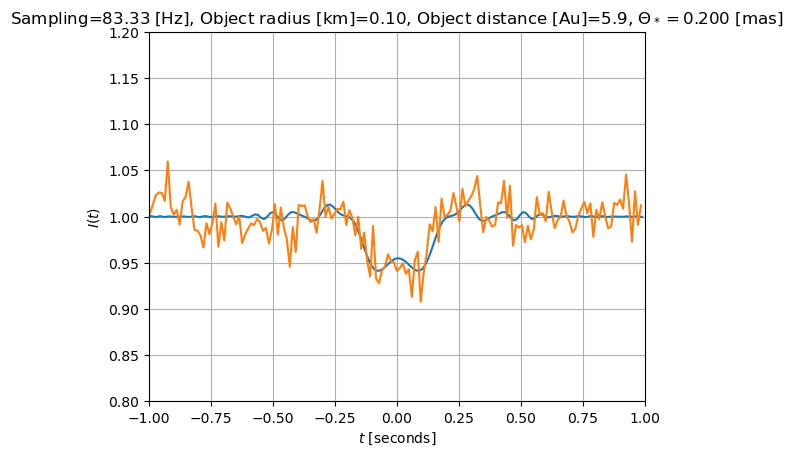

In [253]:
# plot
plt.plot(t, curve)
plt.plot(targ_t, targ_y)
plt.xlim(-1,1) # time interval (-1 second to  +1 second)
plt.ylim(0.8, 1.2)
plt.title('Sampling=%.2f [Hz], Object radius [km]=%.2f, Object distance [Au]=%.1f, $\Theta_*=%.3f$ [mas]' % (1/exposure, objectRad/1e3, dist, angDi))
plt.xlabel('$t$ [seconds]')
plt.ylabel('$I(t)$')
plt.grid()
plt.show();

In [277]:
# event parameters
exposure = 0.012 #0.01215 #0.0012
startLam = 7e-7 #2e-7 # 4e-7 start of wavelength range
endLam = 7e-7 #11e-7 # end of wavelength range
dist = 5.9 # object distance, AU
angDi = 0.2 # angular diameter of star, mas
shiftAdj = 0 # don't touch
phi = 75 # opposition angle, degrees

objectRads = np.arange(10, 150, 10) # object radius, m
impacts = np.arange(100, 240, 10) # impact parameter, m
dest = np.zeros((len(objectRads), len(impacts)))
print('Dest array shape:', dest.shape)
for i,objectRad in tqdm(enumerate(objectRads)):
    for j,impact in enumerate(impacts):
        curve = genCurve(exposure, startLam, endLam, objectRad,
                 impact, dist, angDi, shiftAdj, phi)
        
        t = exposure * np.arange(0, len(curve))
        t -= np.median(t)
        t_clip = 1
        targ_t = t_rel_s[indices[0] - window : indices[-1] + window]
        targ_y = lcs[0]
        targ_y = targ_y[(targ_t >= -t_clip) & (targ_t <= t_clip)]
        targ_t = targ_t[(targ_t >= -t_clip) & (targ_t <= t_clip)]
        curve = curve[(t >= -t_clip) & (t <= t_clip)]
        t = t[(t >= -t_clip) & (t <= t_clip)]
        if len(t) < len(targ_t):
            targ_t = targ_t[find_closest_match(t, targ_t)]
            targ_y = targ_y[find_closest_match(t, targ_t)]
        elif len(targ_t) < len(t):
            t = t[find_closest_match(targ_t, t)]
            curve = curve[find_closest_match(targ_t, t)]

        chi2 = np.sum((curve - targ_y) ** 2)
        dest[i][j] = chi2


Dest array shape: (14, 14)


14it [03:35, 15.41s/it]


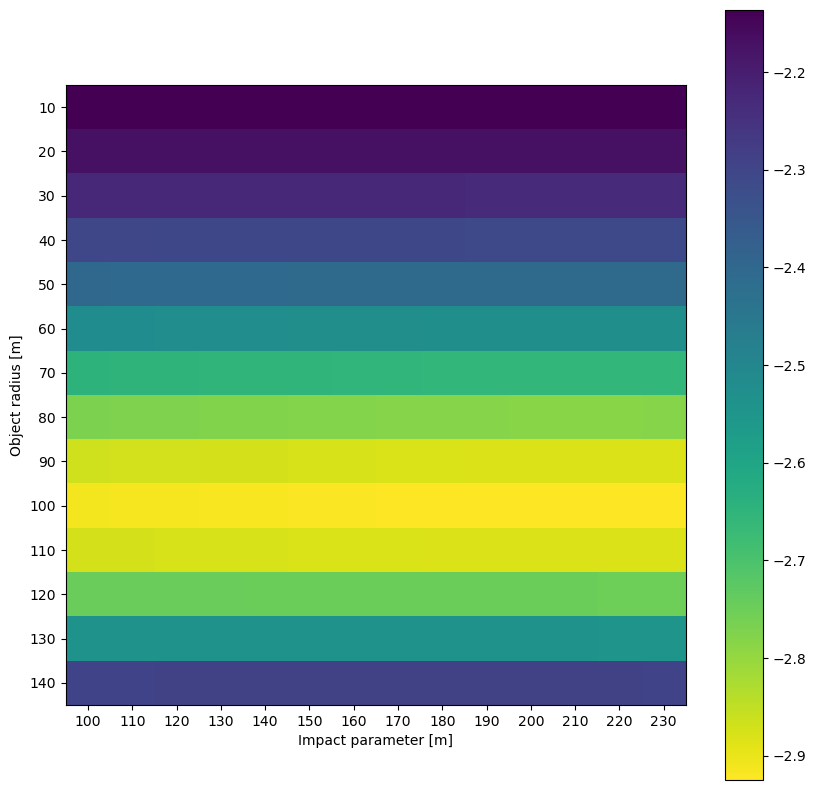

In [288]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(dest), cmap='viridis_r')
plt.yticks(ticks=np.arange(0, dest.shape[0]), labels=objectRads)
plt.xticks(ticks=np.arange(0, dest.shape[1]), labels=impacts)
plt.xlabel('Impact parameter [m]')
plt.ylabel('Object radius [m]')
plt.colorbar();

In [279]:
xc, yc = np.where(dest == np.min(dest))
objectRad_, impact_ = objectRads[xc[0]], impacts[yc[0]]
objectRad_, impact_

(100, 200)

In [295]:
# event parameters
exposure = 0.012 #0.01215 #0.0012
startLam = 7e-7 #2e-7 # 4e-7 start of wavelength range
endLam = 7e-7 #11e-7 # end of wavelength range
dist = 5.9 # object distance, AU
angDi = 0.2 # angular diameter of star, mas
shiftAdj = 0 # don't touch
phi = 75 # opposition angle, degrees

curve = genCurve(exposure, startLam, endLam, objectRad_,
         impact_, dist, angDi, shiftAdj, phi)

t = exposure * np.arange(0, len(curve))
t -= np.median(t)
t_clip = 1
targ_t = t_rel_s[indices[0] - window : indices[-1] + window]
targ_y = lcs[0]
targ_y = targ_y[(targ_t >= -t_clip) & (targ_t <= t_clip)]
targ_t = targ_t[(targ_t >= -t_clip) & (targ_t <= t_clip)]
curve = curve[(t >= -t_clip) & (t <= t_clip)]
t = t[(t >= -t_clip) & (t <= t_clip)]
if len(t) < len(targ_t):
    targ_t = targ_t[find_closest_match(t, targ_t)]
    targ_y = targ_y[find_closest_match(t, targ_t)]
elif len(targ_t) < len(t):
    t = t[find_closest_match(targ_t, t)]
    curve = curve[find_closest_match(targ_t, t)]

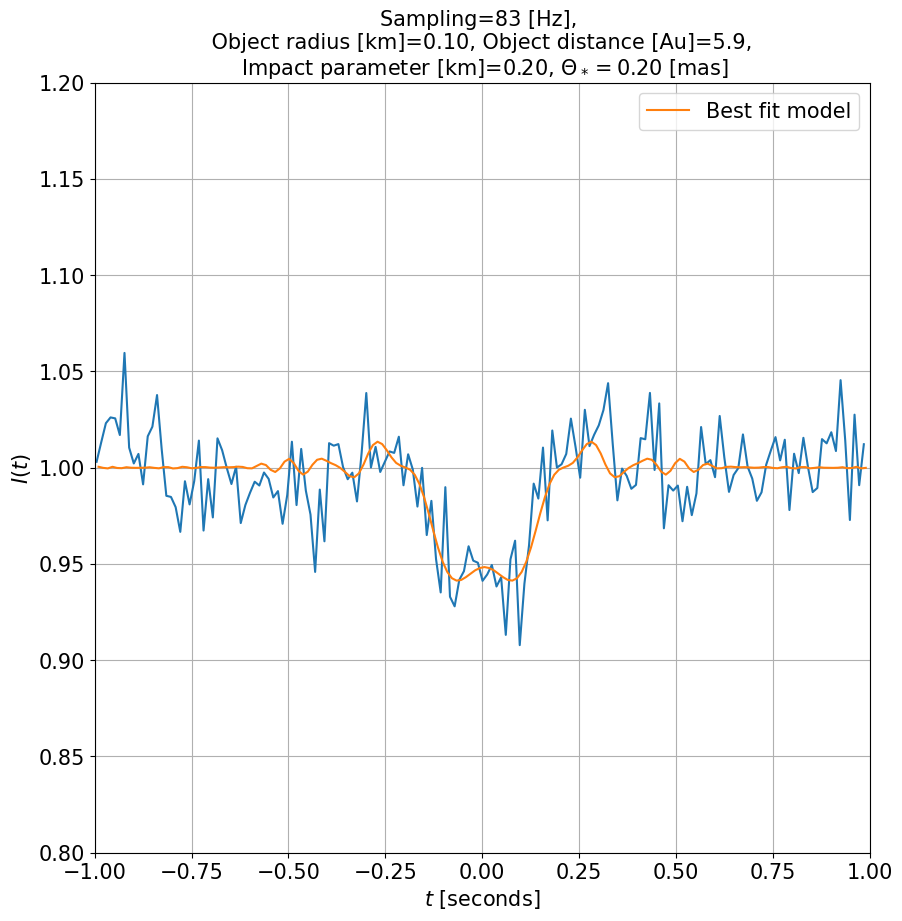

In [306]:
# plot
fs = 15
plt.figure(figsize=(10,10))
plt.plot(targ_t, targ_y, c='tab:blue')
plt.plot(t, curve, c='tab:orange', label='Best fit model')
plt.xlim(-1,1) # time interval (-1 second to  +1 second)
plt.ylim(0.8, 1.2)
plt.title('Sampling=%d [Hz], \n Object radius [km]=%.2f, Object distance [Au]=%.1f, \n Impact parameter [km]=%.2f, $\Theta_*=%.2f$ [mas]' % (1/exposure, objectRad_/1e3, dist, impact_/1e3, angDi), fontsize=fs)
plt.xlabel('$t$ [seconds]', fontsize=fs)
plt.ylabel('$I(t)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()
plt.legend(fontsize=fs)
plt.show();

In [129]:
# (fixed) event parameters
exposure = 0.01215 #0.0012
startLam = 7e-7 #2e-7 # 4e-7 start of wavelength range
endLam = 7e-7 #11e-7 # end of wavelength range
dist = 5.9 # object distance, AU
angDi = 0.01 # angular diameter of star, mas
shiftAdj = 0 # don't touch
phi = 0 # opposition angle, degrees

objectRads = np.arange(10, 500, 10)
impacts = np.arange(0, 510, 10)
dest = np.zeros((len(objectRads), len(impacts)))
print('Dest array shape:', dest.shape)
for i,objectRad in tqdm(enumerate(objectRads)):
    for j,impact in enumerate(impacts):
        curve = genCurve(exposure, startLam, endLam, objectRad,
                 impact, dist, angDi, shiftAdj, phi)
        t = exposure * np.arange(0, len(curve))
        t -= np.median(t)
        curve = curve[(t >= -2) & (t <= 2)]
        #t = t[(t >= -2) & (t <= 2)]
        chi2 = np.sum((curve - targ_y) ** 2)
        #print(objectRad, impact, chi2)
        dest[i][j] = chi2

Dest array shape: (49, 51)


49it [46:17, 56.69s/it]


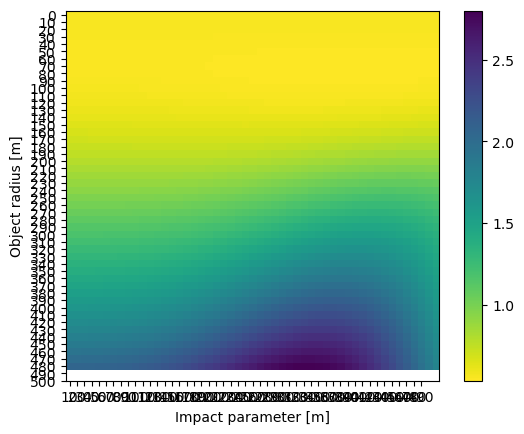

In [134]:
plt.imshow(dest, cmap='viridis_r')
plt.xticks(ticks=np.arange(0, dest.shape[0]), labels=objectRads)
plt.yticks(ticks=np.arange(0, dest.shape[1]), labels=impacts)
plt.xlabel('Impact parameter [m]')
plt.ylabel('Object radius [m]')
plt.colorbar();

In [151]:
# best fit params
xc, yc = np.where(dest == np.min(dest))
xc[0], yc[0]

(7, 39)

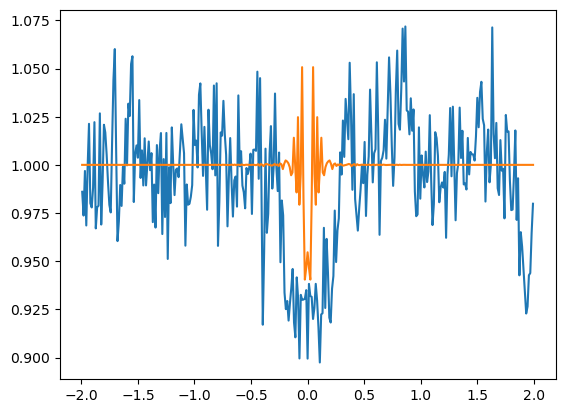

In [156]:
curve = genCurve(exposure, startLam, endLam, objectRads[xc[0]],
         impacts[yc[0]], dist, angDi, shiftAdj, phi)
t = exposure * np.arange(0, len(curve))
t -= np.median(t)
curve = curve[(t >= -2) & (t <= 2)]
t = t[(t >= -2) & (t <= 2)]
plt.plot(targ_t, targ_y)
plt.plot(t, curve)

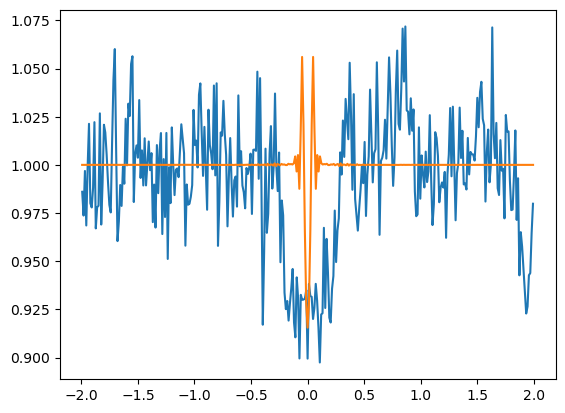

In [22]:
# (fixed) event parameters
exposure = 0.01215 #0.0012
startLam = 2e-7 #2e-7 # 4e-7 start of wavelength range
endLam = 11e-7 #11e-7 # end of wavelength range
dist = 5.9 # object distance, AU
angDi = 0.01 # angular diameter of star, mas
shiftAdj = 0 # don't touch
phi = 45 # opposition angle, degrees

objectRad = 100
impact = 500

curve = genCurve(exposure, startLam, endLam, objectRad,
         impact, dist, angDi, shiftAdj, phi)
t = exposure * np.arange(0, len(curve))
t -= np.median(t)
curve = curve[(t >= -2) & (t <= 2)]
t = t[(t >= -2) & (t <= 2)]
plt.plot(targ_t, targ_y)
plt.plot(t, curve)

In [20]:
curve.shape, targ_y.shape

((329,), (329,))

In [2]:
0.08 * 3200 / 60

4.266666666666667